Baseline
 - https://www.kaggle.com/code/nguyncngph/instacart-lightgbm
 
 - https://www.kaggle.com/code/kokovidis/ml-instacart-f1-0-38-part-one-features

In [1]:
import os
import gc
import time
import zipfile

import pandas as pd
import numpy as np
from pathlib import Path

start = time.time()

In [2]:
DATA_ROOT = Path('data/')

In [3]:
uxp = pd.read_pickle('uxp.pkl')
uxp = uxp.drop(columns=['item_first_ratio', 'item_N2_ratio', 'item_N3_ratio', 'item_N4_ratio', 'item_N5_ratio',
                        'Times_Bought_N', 'Order_Range_D', 'Order_Ratio_user_id_X_product_id'])
uxp.head()

,user_id,product_id,uxp_total_bought,one_shot_ratio_product,times_last5,times_last5_ratio,total_orders,first_order_number,reorder_ratio,mean_add_to_cart_order,order_size_avg
0,1,196.0,10,0.417500,4.0,0.8,11,1,0.776480,3.721774,5.363636
1,1,10258.0,9,0.447038,4.0,0.8,11,2,0.713772,4.277492,5.363636
2,1,10326.0,1,0.478419,NaN,NaN,11,5,0.652009,4.191097,5.363636
3,1,12427.0,10,0.470518,4.0,0.8,11,1,0.740735,4.760037,5.363636
4,1,13032.0,3,0.520218,2.0,0.4,11,2,0.657158,5.622767,5.363636


In [4]:
orders = pd.read_csv(DATA_ROOT / 'orders.csv' )
order_products_train = pd.read_csv(DATA_ROOT / 'order_products__train.csv')

#products = pd.read_csv('../input/instacart-market-basket-analysis/products.csv')

In [5]:
orders_last = orders[(orders.eval_set=='train') | (orders.eval_set=='test') ]

In [6]:
uxp = uxp.merge(orders_last, on='user_id', how='left')
uxp.head(10)

,user_id,product_id,uxp_total_bought,one_shot_ratio_product,times_last5,times_last5_ratio,total_orders,first_order_number,reorder_ratio,mean_add_to_cart_order,order_size_avg,order_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,1,196.0,10,0.417500,4.0,0.8,11,1,0.776480,3.721774,5.363636,1187899,train,11,4,8,14.0
1,1,10258.0,9,0.447038,4.0,0.8,11,2,0.713772,4.277492,5.363636,1187899,train,11,4,8,14.0
2,1,10326.0,1,0.478419,NaN,NaN,11,5,0.652009,4.191097,5.363636,1187899,train,11,4,8,14.0
3,1,12427.0,10,0.470518,4.0,0.8,11,1,0.740735,4.760037,5.363636,1187899,train,11,4,8,14.0
4,1,13032.0,3,0.520218,2.0,0.4,11,2,0.657158,5.622767,5.363636,1187899,train,11,4,8,14.0
5,1,13176.0,2,0.288116,NaN,NaN,11,2,0.832555,5.095947,5.363636,1187899,train,11,4,8,14.0
6,1,14084.0,1,0.370850,NaN,NaN,11,1,0.810982,5.792595,5.363636,1187899,train,11,4,8,14.0
7,1,17122.0,1,0.472574,NaN,NaN,11,5,0.675576,6.257421,5.363636,1187899,train,11,4,8,14.0
8,1,25133.0,8,0.419255,4.0,0.8,11,3,0.740155,7.001614,5.363636,1187899,train,11,4,8,14.0
9,1,26088.0,2,0.595013,NaN,NaN,11,1,0.539041,6.495838,5.363636,1187899,train,11,4,8,14.0


In [7]:
uxp_train = uxp[uxp.eval_set=='train']

uxp_train = uxp_train.merge(order_products_train, on=['product_id', 'order_id'], how='left' )

uxp_train = uxp_train.drop(['order_id','eval_set', 'add_to_cart_order'], axis=1)
uxp_train = uxp_train.fillna(0)
uxp_train.head(20)

,user_id,product_id,uxp_total_bought,one_shot_ratio_product,times_last5,times_last5_ratio,total_orders,first_order_number,reorder_ratio,mean_add_to_cart_order,order_size_avg,order_number,order_dow,order_hour_of_day,days_since_prior_order,reordered
0,1,196.0,10,0.417500,4.0,0.8,11,1,0.776480,3.721774,5.363636,11,4,8,14.0,1.0
1,1,10258.0,9,0.447038,4.0,0.8,11,2,0.713772,4.277492,5.363636,11,4,8,14.0,1.0
2,1,10326.0,1,0.478419,0.0,0.0,11,5,0.652009,4.191097,5.363636,11,4,8,14.0,0.0
3,1,12427.0,10,0.470518,4.0,0.8,11,1,0.740735,4.760037,5.363636,11,4,8,14.0,0.0
4,1,13032.0,3,0.520218,2.0,0.4,11,2,0.657158,5.622767,5.363636,11,4,8,14.0,1.0
5,1,13176.0,2,0.288116,0.0,0.0,11,2,0.832555,5.095947,5.363636,11,4,8,14.0,0.0
6,1,14084.0,1,0.370850,0.0,0.0,11,1,0.810982,5.792595,5.363636,11,4,8,14.0,0.0
7,1,17122.0,1,0.472574,0.0,0.0,11,5,0.675576,6.257421,5.363636,11,4,8,14.0,0.0
8,1,25133.0,8,0.419255,4.0,0.8,11,3,0.740155,7.001614,5.363636,11,4,8,14.0,1.0
9,1,26088.0,2,0.595013,0.0,0.0,11,1,0.539041,6.495838,5.363636,11,4,8,14.0,1.0


In [8]:
uxp_test = uxp[uxp.eval_set=='test']
uxp_test = uxp_test.drop(['eval_set', 'order_id'], axis=1)
uxp_test = uxp_test.fillna(0)
uxp_test.head(20)

,user_id,product_id,uxp_total_bought,one_shot_ratio_product,times_last5,times_last5_ratio,total_orders,first_order_number,reorder_ratio,mean_add_to_cart_order,order_size_avg,order_number,order_dow,order_hour_of_day,days_since_prior_order
120,3,248.0,1,0.720492,0.0,0.0,13,2,0.400251,10.620782,6.769231,13,5,15,11.0
121,3,1005.0,1,0.687259,1.0,0.2,13,10,0.440605,9.498920,6.769231,13,5,15,11.0
122,3,1819.0,3,0.653128,0.0,0.0,13,4,0.492162,9.287541,6.769231,13,5,15,11.0
123,3,7503.0,1,0.616269,0.0,0.0,13,3,0.553551,9.547379,6.769231,13,5,15,11.0
124,3,8021.0,1,0.559164,0.0,0.0,13,2,0.591157,8.822854,6.769231,13,5,15,11.0
125,3,9387.0,5,0.530830,0.0,0.0,13,1,0.650427,7.476027,6.769231,13,5,15,11.0
126,3,12845.0,1,0.742956,0.0,0.0,13,4,0.362920,10.444101,6.769231,13,5,15,11.0
127,3,14992.0,2,0.572936,0.0,0.0,13,6,0.582820,9.240669,6.769231,13,5,15,11.0
128,3,15143.0,1,0.641919,0.0,0.0,13,1,0.492022,8.714824,6.769231,13,5,15,11.0
129,3,16797.0,3,0.433382,1.0,0.2,13,1,0.698155,7.116096,6.769231,13,5,15,11.0


In [9]:
del uxp
del orders_last
gc.collect()

0

In [10]:
uxp_train = uxp_train.set_index(['user_id', 'product_id'])

'''#BALANCE REORDERED ROWS
uxp_train_bal = uxp_train.copy()
uxp_train_bal = uxp_train_bal[uxp_train_bal.reordered==0].sample(n=uxp_train_bal[uxp_train_bal.reordered==1].shape[0])
uxp_train_bal = pd.concat([uxp_train_bal, uxp_train[uxp_train.reordered==1]])
uxp_train_bal = uxp_train_bal.sample(frac=1)
uxp_train = uxp_train_bal.copy()
print(uxp_train.reordered.value_counts())
del uxp_train_bal
gc.collect()'''


uxp_test = uxp_test.set_index(['user_id', 'product_id'])

In [11]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
uxp_train.loc[:, 'reordered'] = uxp_train.reordered.fillna(0)


# subsample
X_train, X_val, y_train, y_val = train_test_split(uxp_train.drop('reordered', axis=1), uxp_train.reordered,
                                                    test_size=0.2, random_state=42)

'''del uxp_train'''
gc.collect()

import lightgbm as lgb
d_train = lgb.Dataset(X_train, 
                     label=y_train)
del X_train, y_train

In [12]:
params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': {'binary_logloss'},
    'num_leaves': 96,
    'max_depth': 10,
    'feature_fraction': 0.76,
    'bagging_fraction': 0.75,
    'bagging_freq': 5
}
ROUNDS = 50

print('light GBM train :-)')
model = lgb.train(params, d_train, ROUNDS)

light GBM train :-)
[LightGBM] [Info] Number of positive: 662665, number of negative: 6117063
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.061388 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1451
[LightGBM] [Info] Number of data points in the train set: 6779728, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.097742 -> initscore=-2.222568
[LightGBM] [Info] Start training from score -2.222568


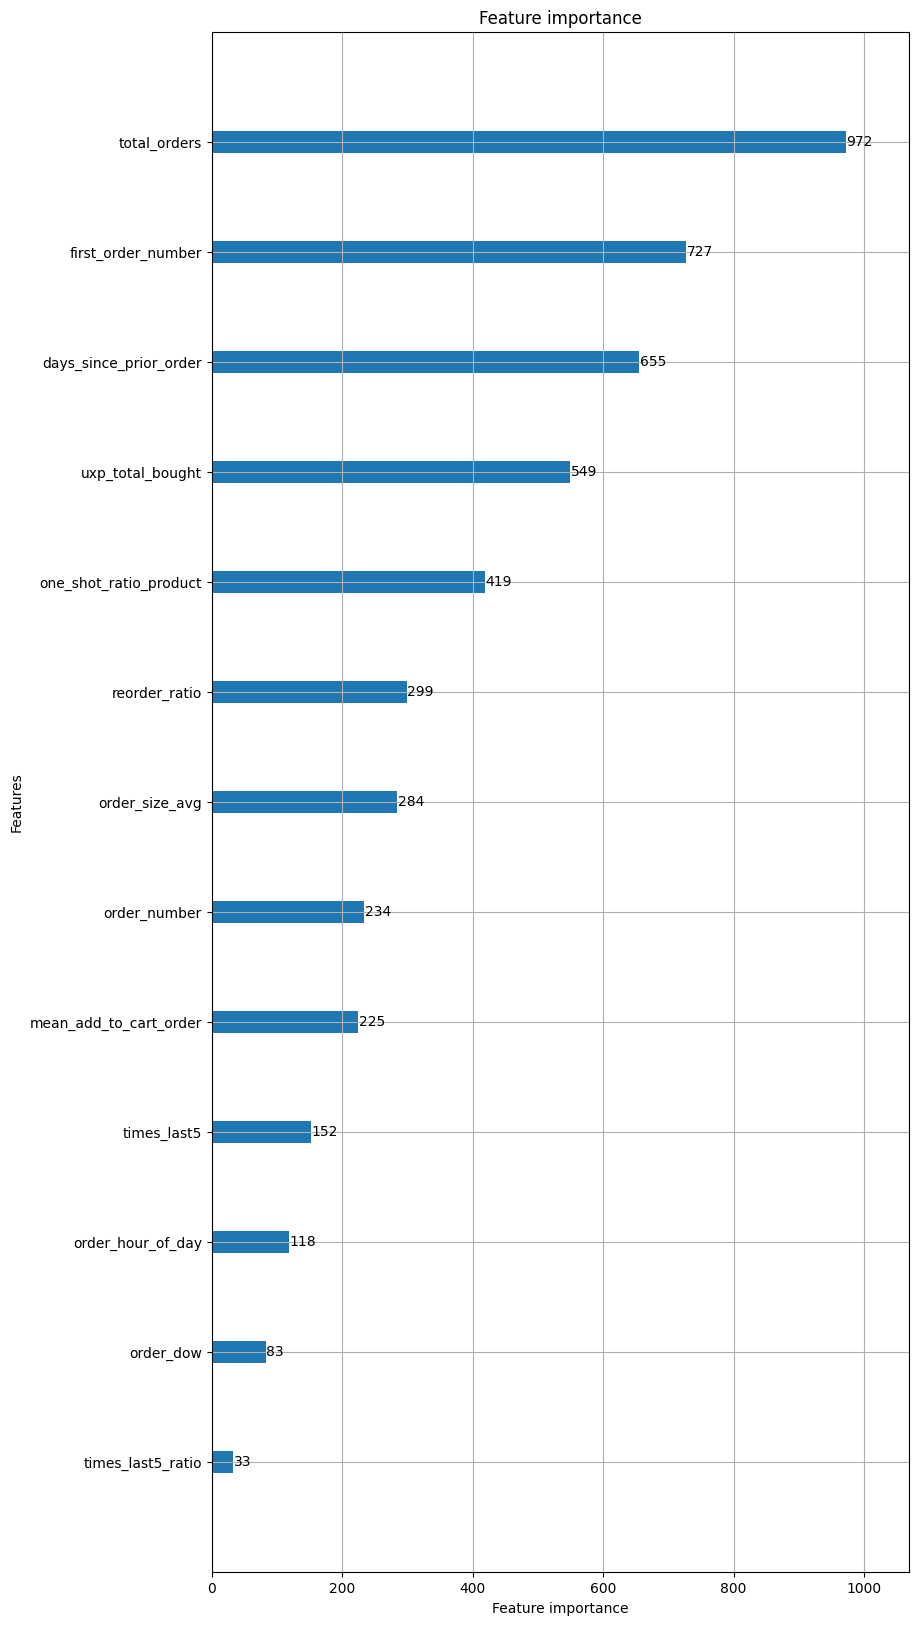

In [13]:
lgb.plot_importance(model, figsize=(9, 20))
del d_train

In [14]:
X_val

,,uxp_total_bought,one_shot_ratio_product,times_last5,times_last5_ratio,total_orders,first_order_number,reorder_ratio,mean_add_to_cart_order,order_size_avg,order_number,order_dow,order_hour_of_day,days_since_prior_order
user_id,product_id,,,,,,,,,,,,,
133414,5428.0,19,0.429907,3.0,0.6,24,1,0.737745,5.579167,6.958333,24,3,14,2.0
107612,49099.0,1,0.712575,0.0,0.0,10,3,0.422145,7.692042,17.400000,10,5,9,14.0
69469,8021.0,1,0.559164,0.0,0.0,29,18,0.591157,8.822854,5.827586,29,1,11,14.0
190574,6377.0,1,0.735526,0.0,0.0,34,11,0.391513,8.791833,5.441176,34,4,19,30.0
196693,17758.0,3,0.550735,1.0,0.2,17,9,0.590403,8.379580,23.294118,17,1,22,22.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145083,39275.0,11,0.485944,2.0,0.4,66,11,0.628843,8.192694,10.606061,66,6,12,7.0
192880,27247.0,1,0.414756,0.0,0.0,19,2,0.780477,6.270956,10.736842,19,1,17,30.0
138840,47141.0,1,0.527436,0.0,0.0,16,3,0.663358,5.953388,9.562500,16,6,12,18.0


In [15]:
y_val

user_id  product_id
133414   5428.0        1.0
107612   49099.0       0.0
69469    8021.0        0.0
190574   6377.0        1.0
196693   17758.0       0.0
                      ... 
145083   39275.0       0.0
192880   27247.0       0.0
138840   47141.0       0.0
47309    23395.0       0.0
76158    27241.0       0.0
Name: reordered, Length: 1694933, dtype: float64

In [16]:
y_pred = model.predict(X_val)
y_pred

array([0.46032382, 0.03158829, 0.02333711, ..., 0.02357471, 0.00599888,
       0.00753484])

In [17]:
bin_pred = []

for pred in y_pred:
    bin_pred.append(1 if pred > 0.22 else 0)

y_pred = np.array(bin_pred)
y_pred

array([1, 0, 0, ..., 0, 0, 0])

In [18]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

accuracy = accuracy_score(y_val, y_pred)
print(f'정확도 : {accuracy}')
print(classification_report(y_val, y_pred))
print(confusion_matrix(y_val, y_pred))

정확도 : 0.8769261085836432
              precision    recall  f1-score   support

         0.0       0.94      0.92      0.93   1528774
         1.0       0.39      0.48      0.43    166159

    accuracy                           0.88   1694933
   macro avg       0.67      0.70      0.68   1694933
weighted avg       0.89      0.88      0.88   1694933

[[1406802  121972]
 [  86630   79529]]
